
✅ Dataframes loaded!
✅ Training shape: torch.Size([17560, 60, 17])
✅ Validation shape: torch.Size([4430, 60, 17])
✅ Test shape: torch.Size([5010, 60, 17])
StockLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(17, 128, batch_first=True)
    (1): LSTM(128, 64, batch_first=True)
    (2-3): 2 x LSTM(64, 64, batch_first=True)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)
Training on device: cuda


/tmp/ipykernel_31854/818607689.py:147: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  train_loss += loss.item()


Epoch [1/1500] - Train Loss: 22.1642, Val Loss: 32.1800
Epoch [10/1500] - Train Loss: 22.1353, Val Loss: 31.9203
Epoch [20/1500] - Train Loss: 22.1325, Val Loss: 31.8697
Epoch [30/1500] - Train Loss: 22.1259, Val Loss: 31.9677
Epoch [40/1500] - Train Loss: 22.1330, Val Loss: 31.9344
Epoch [50/1500] - Train Loss: 22.1284, Val Loss: 31.9488
Epoch [60/1500] - Train Loss: 21.9947, Val Loss: 31.7921
Epoch [70/1500] - Train Loss: 21.9396, Val Loss: 31.7252
Epoch [80/1500] - Train Loss: 21.6691, Val Loss: 31.7507
Epoch [90/1500] - Train Loss: 21.3941, Val Loss: 31.9695
Epoch [100/1500] - Train Loss: 22.1270, Val Loss: 31.8908
Epoch [110/1500] - Train Loss: 21.8861, Val Loss: 31.8346
Epoch [120/1500] - Train Loss: 21.8271, Val Loss: 31.8676
Epoch [130/1500] - Train Loss: 21.7188, Val Loss: 31.8135
Epoch [140/1500] - Train Loss: 21.6338, Val Loss: 31.8202
Epoch [150/1500] - Train Loss: 21.5536, Val Loss: 31.7705
Epoch [160/1500] - Train Loss: 21.5211, Val Loss: 31.8171
Epoch [170/1500] - Train 

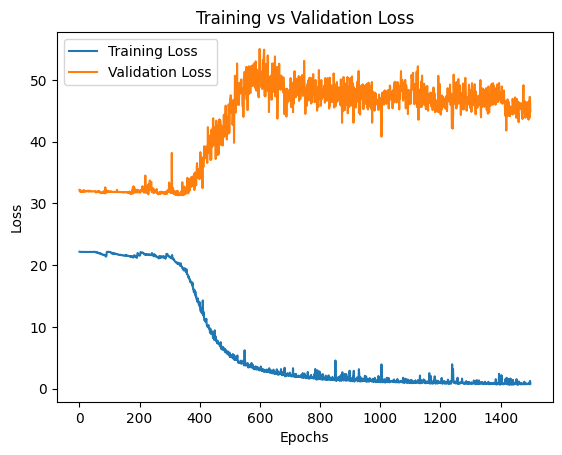

Mean Absolute Error (MAE): 4.5498
Mean Squared Error (MSE): 37.2675
R-squared: -0.3994


In [1]:
# ==== Cell 1: Load Data ====
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load datasets
train_df = pd.read_csv('Training/train_2013_2020.csv', parse_dates=["Date"])
valid_df = pd.read_csv('Training/valid_2021_2022.csv', parse_dates=["Date"])
test_df = pd.read_csv('Training/test_2023_2025.csv', parse_dates=["Date"])

print("\n✅ Dataframes loaded!")

# ==== Cell 2: Preprocessing ====
# Sort data and encode ticker
for df in [train_df, valid_df, test_df]:
    df.sort_values(by=["Date", "Ticker"], inplace=True)

label_encoder = LabelEncoder()
train_df['Ticker'] = label_encoder.fit_transform(train_df['Ticker'])
valid_df['Ticker'] = label_encoder.transform(valid_df['Ticker'])
test_df['Ticker'] = label_encoder.transform(test_df['Ticker'])

# Separate features and target
def prepare_features_targets(df):
    X = df.drop(columns=["Date", "5_day_return"])
    y = df["5_day_return"].values
    tickers = df["Ticker"].values
    return X, y, tickers

X_train_df, y_train, ticker_train = prepare_features_targets(train_df)
X_val_df, y_val, ticker_val = prepare_features_targets(valid_df)
X_test_df, y_test, ticker_test = prepare_features_targets(test_df)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_df)
X_val = scaler.transform(X_val_df)
X_test = scaler.transform(X_test_df)

# ==== Cell 3: Sequence Preparation ====
def create_sequences_per_ticker(features, targets, tickers, window_size=60):
    X, y = [], []
    unique_tickers = np.unique(tickers)
    for ticker in unique_tickers:
        idxs = np.where(tickers == ticker)[0]
        f = features[idxs]
        t = targets[idxs]
        if len(f) < window_size:
            continue
        for i in range(window_size, len(f)):
            X.append(f[i - window_size:i])
            y.append(t[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_per_ticker(X_train, y_train, ticker_train)
X_val, y_val = create_sequences_per_ticker(X_val, y_val, ticker_val)
X_test, y_test = create_sequences_per_ticker(X_test, y_test, ticker_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

print(f"✅ Training shape: {X_train_tensor.shape}")
print(f"✅ Validation shape: {X_val_tensor.shape}")
print(f"✅ Test shape: {X_test_tensor.shape}")


# ==== Cell 4: Model Definition ====
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes=[64, 32], fc_sizes=[16], dropout=0.0):
        super(StockLSTM, self).__init__()

        self.lstm_layers = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.lstm_layers.append(nn.LSTM(input_size=in_size, hidden_size=hidden_size, batch_first=True))
            in_size = hidden_size

        self.fc_layers = nn.ModuleList()
        for fc_size in fc_sizes:
            self.fc_layers.append(nn.Linear(in_size, fc_size))
            in_size = fc_size

        self.output_layer = nn.Linear(in_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        x = x[:, -1, :]  # Last time step
        for fc in self.fc_layers:
            x = self.relu(fc(x))
            x = self.dropout(x)
        return self.output_layer(x)

# ==== Cell 5: Model Initialization ====
input_size = X_train_tensor.shape[2]

# Adjust the structure here:
model = StockLSTM(
    input_size,
    hidden_sizes=[128, 64, 64, 64],  # LSTM layers: list of hidden sizes, one per layer
    fc_sizes=[64, 32],           # Fully connected layers: list of layer sizes
    dropout=0.1                  # Dropout applied after each FC layer (not LSTM layers)
)

print(model)

# ==== Cell 6: Training ====
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Training on device: {device}")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1500
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# ==== Cell 7: Plotting ====
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# ==== Cell 8: Evaluation ====
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")



📊 Evaluation Results:
Mean Absolute Error (MAE): 4.5498
Mean Squared Error (MSE): 37.2675
R-squared: -0.3994


/tmp/ipykernel_31854/1225657484.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jesse/Projects/myenvs/torch_nightly/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


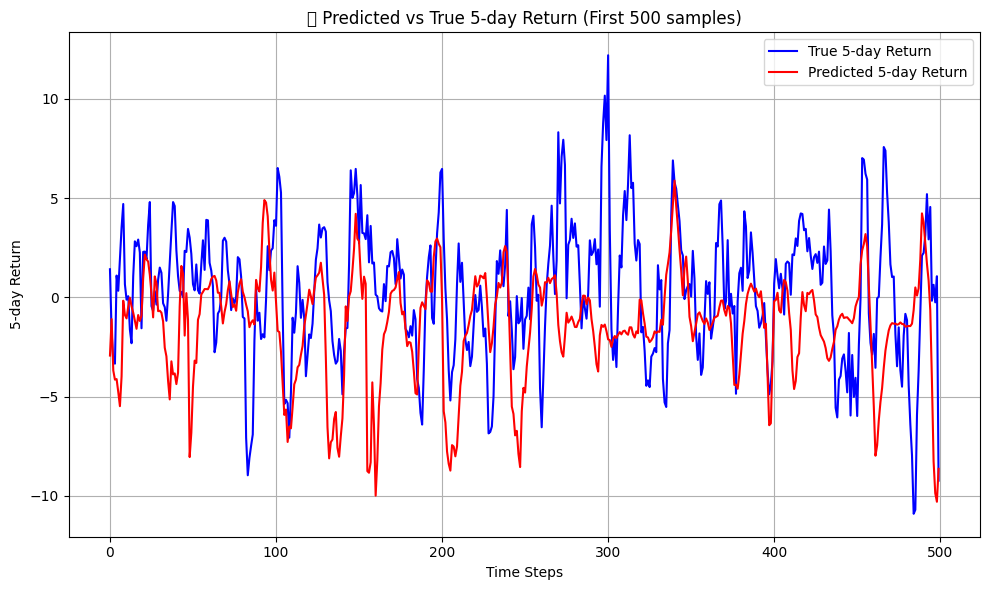

In [5]:
# ==== Cell 8: Evaluation and Visualization ====
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

model.eval()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n📊 Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plotting predicted vs true values (for first 1000 time steps)
plt.figure(figsize=(10, 6))
plt.plot(y_true[:500], label="True 5-day Return", color='blue')
plt.plot(y_pred[:500], label="Predicted 5-day Return", color='red')
plt.title("📈 Predicted vs True 5-day Return (First 500 samples)")
plt.xlabel("Time Steps")
plt.ylabel("5-day Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
